# 1. General data exploration

In [1]:
import pandas as pd
activities_df = pd.read_csv('data/strava_activities.csv')

# Count the number of activities for each Activity Type
activity_counts = activities_df['Activity Type'].value_counts()
activity_counts

Run                1553
Ride                487
Swim                223
Virtual Ride         46
Weight Training      31
Workout               8
Walk                  3
Name: Activity Type, dtype: int64

In [2]:
# Look at how many rides have recorded Average Watts and Average Heart Rate

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Average Watts'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_77605/950879621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


237

In [3]:
# Look at how many rides have recorded Weighted Average Watts and Average Heart Rate

ride_activities = activities_df[activities_df['Activity Type'] == 'Ride']

# Convert 'Distance' to a numeric value for comparison
ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')

# Filter for rides over 10 distance units and with recorded Average Watts and Average Heart Rate
filtered_rides = ride_activities[(ride_activities['Distance'] > 10) & 
                                 (ride_activities['Weighted Average Power'].notna()) & 
                                 (ride_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_ride_count = len(filtered_rides)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_77605/4091331926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride_activities['Distance'] = pd.to_numeric(ride_activities['Distance'], errors='coerce')


181

In [4]:
# Look at how many runs have recorded Average Watts and Average Heart Rate

# Filter for 'Run' activities
run_activities = activities_df[activities_df['Activity Type'] == 'Run']

# Filter for runs with recorded Average Watts and Average Heart Rate
filtered_runs = run_activities[(run_activities['Weighted Average Power'].notna()) & 
                               (run_activities['Average Heart Rate'].notna())]

# Count the number of such activities
filtered_run_count = len(filtered_runs)
filtered_run_count


167

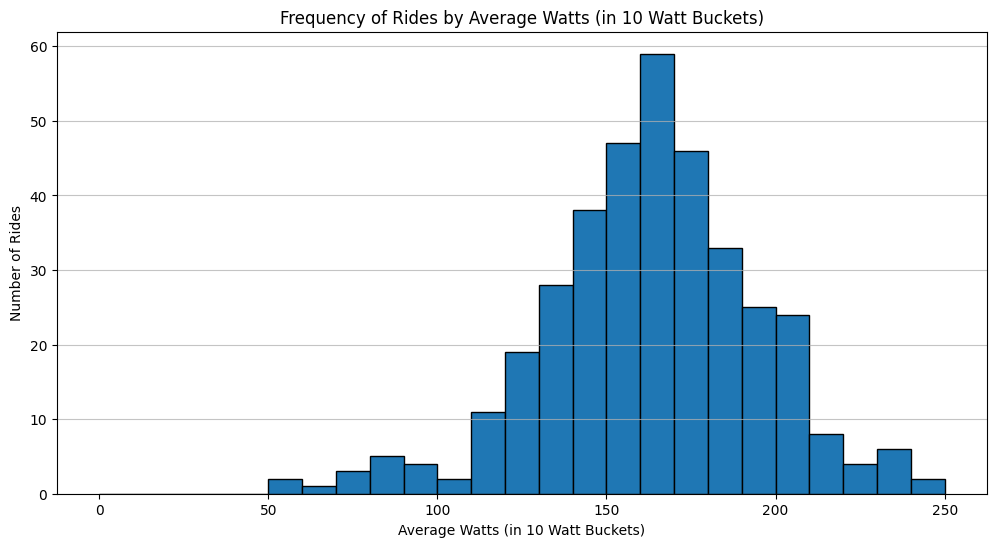

In [5]:
# View the power ranges in the summary file

import matplotlib.pyplot as plt
import numpy as np

# Dropping NaN values from 'Average Watts' for plotting
ride_watts = ride_activities['Weighted Average Power'].dropna()

# Creating a histogram
plt.figure(figsize=(12, 6))
plt.hist(ride_watts, bins=np.arange(0, ride_watts.max() + 10, 10), edgecolor='black')
plt.title('Frequency of Rides by Average Watts (in 10 Watt Buckets)')
plt.xlabel('Average Watts (in 10 Watt Buckets)')
plt.ylabel('Number of Rides')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [6]:
import csv
import gzip
from fitparse import FitFile

def fit_gz_to_csv(fit_gz_file_path, csv_file_path):
    # Decompress the .fit.gz file and parse it
    with gzip.open(fit_gz_file_path, 'rb') as f:
        fitfile = FitFile(f)

        # Open or create the CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            headers_written = False

            # Iterate over all messages of type 'record'
            # (other types include 'device_info', 'activity', etc)
            for record in fitfile.get_messages('record'):

                # Get all data values from the record
                data = record.get_values()

                # Write the headers once
                if not headers_written:
                    writer.writerow(data.keys())
                    headers_written = True

                # Write the data values
                writer.writerow(data.values())

# Example usage
fit_gz_to_csv('data/2629768938.fit.gz', 'data/2629768938.csv')


In [7]:
import csv
import gzip
from fitparse import FitFile

def fit_gz_to_csv(fit_gz_file_path, csv_file_path):
    # Decompress the .fit.gz file and parse it
    with gzip.open(fit_gz_file_path, 'rb') as f:
        fitfile = FitFile(f)

        # Collect all unique field names from all records
        field_names = set()
        for record in fitfile.get_messages('record'):
            field_names.update(record.get_values().keys())

        # Sort field names for consistent column ordering
        field_names = sorted(field_names)

        # Open or create the CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=field_names)
            writer.writeheader()

            # Write data for each record
            for record in fitfile.get_messages('record'):
                data = record.get_values()
                writer.writerow(data)

# Example usage
fit_gz_to_csv('data/3117764808.fit.gz', 'data/3117764808.csv')


In [8]:
import pandas as pd

csv_file_path = 'data/3117764808.csv'
ride_data_df = pd.read_csv(csv_file_path)

# Calculate average power and average heart rate
average_power = ride_data_df['power'].mean()
average_heart_rate = ride_data_df['heart_rate'].mean()

average_power, average_heart_rate


(104.86805736636245, 107.90795306388527)

In [9]:
# Exclude power readings when the bike is stationary (assuming power is zero when stationary)
active_power_readings = ride_data_df[ride_data_df['power'] > 0]

# Calculate the average power excluding stationary periods
average_active_power = active_power_readings['power'].mean()
average_active_power


128.81774503523383

In [10]:
def max_power(data, max_durations):
    max_powers = {duration: 0 for duration in max_durations}
    power_sum = {duration: 0 for duration in max_durations}
    power_queue = {duration: [] for duration in max_durations}

    for power in data['power']:
        for duration in max_durations:
            # Add current power to the queue and sum for each duration
            power_queue[duration].append(power)
            power_sum[duration] += power

            # If the queue length exceeds the duration, subtract the oldest power and remove it from the queue
            if len(power_queue[duration]) > duration:
                power_sum[duration] -= power_queue[duration].pop(0)

            # Update the maximum power if the current average is higher
            if len(power_queue[duration]) == duration:
                avg_power = power_sum[duration] / duration
                max_powers[duration] = max(max_powers[duration], avg_power)

    return max_powers


In [14]:
def max_power(data, max_durations):
    max_powers = {duration: 0 for duration in max_durations}
    power_sum = {duration: 0 for duration in max_durations}
    power_queue = {duration: [] for duration in max_durations}

    for power in data['power']:
        for duration in max_durations:
            # Add current power to the queue and sum for each duration
            power_queue[duration].append(power)
            power_sum[duration] += power

            # If the queue length exceeds the duration, subtract the oldest power and remove it from the queue
            if len(power_queue[duration]) > duration:
                power_sum[duration] -= power_queue[duration].pop(0)

            # Update the maximum power if the current average is higher
            if len(power_queue[duration]) == duration:
                avg_power = power_sum[duration] / duration
                max_powers[duration] = max(max_powers[duration], avg_power)

    # Convert the dictionary of max powers into a list of pairs (duration, max power)
    max_power_pairs = [(duration, power) for duration, power in max_powers.items()]
    return max_power_pairs

def format_duration(seconds):
    if seconds < 60:
        return f"{seconds} s"
    elif seconds < 3600:
        return f"{seconds / 60:.1f} min"
    else:
        return f"{seconds / 3600:.1f} hr"

In [15]:
# Durations in seconds for which to calculate max power
durations = [5, 10, 30, 60, 5*60, 10*60, 20*60, 30*60, 60*60, 90*60, 120*60]  # 5s, 10s, 30s, 60s, and 5min

# Calculate max power for each duration
power_curve = max_power(ride_data_df, durations)
power_curve

[(5, 439.2),
 (10, 412.9),
 (30, 342.06666666666666),
 (60, 221.18333333333334),
 (300, 162.23333333333332),
 (600, 136.31333333333333),
 (1200, 120.79166666666667),
 (1800, 109.76),
 (3600, 105.42472222222223),
 (5400, 0),
 (7200, 0)]

In [16]:
# Filter out tuples where the power value is 0 and format durations
filtered_durations = []
filtered_powers = []

for duration, power in power_curve:
    if power > 0:
        filtered_durations.append(format_duration(duration))
        filtered_powers.append(power)
        print(f"Duration: {format_duration(duration)}, Power: {power} Watts")


Duration: 5 s, Power: 439.2 Watts
Duration: 10 s, Power: 412.9 Watts
Duration: 30 s, Power: 342.06666666666666 Watts
Duration: 1.0 min, Power: 221.18333333333334 Watts
Duration: 5.0 min, Power: 162.23333333333332 Watts
Duration: 10.0 min, Power: 136.31333333333333 Watts
Duration: 20.0 min, Power: 120.79166666666667 Watts
Duration: 30.0 min, Power: 109.76 Watts
Duration: 1.0 hr, Power: 105.42472222222223 Watts


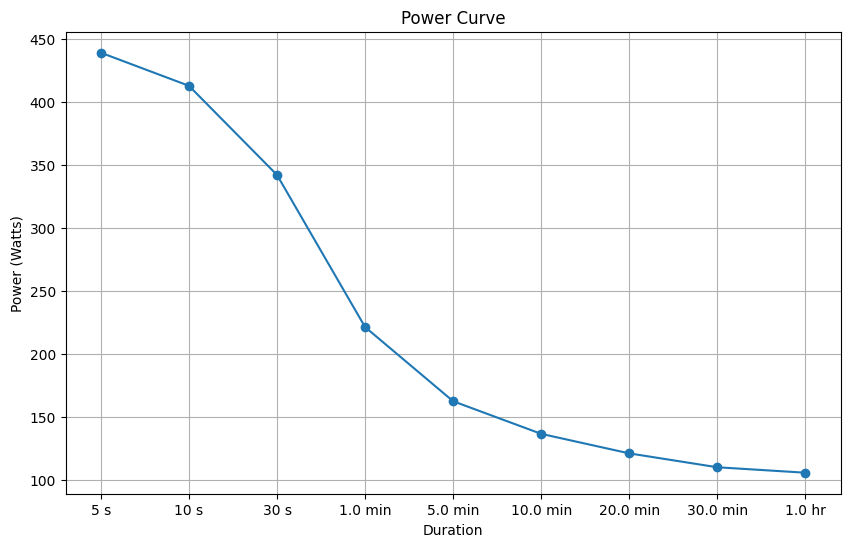

In [17]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_durations, filtered_powers, marker='o')
plt.xlabel('Duration')
plt.ylabel('Power (Watts)')
plt.title('Power Curve')
plt.grid(True)
plt.show()

# 2. Lean up the data file

## 2.1 Extract only the rides and runs that have power and heart rate information recorded.

In [23]:
import pandas as pd

# Reload the CSV file and check for empty fields
activities_df = pd.read_csv('data/strava_activities.csv')

In [26]:
# Look at how many rides have recorded Weighted Average Watts and Average Heart Rate

target_activities = activities_df[activities_df['Activity Type'].isin(['Ride', 'Virtual Ride', 'Run'])]

# Convert 'Distance' to a numeric value for comparison
target_activities['Distance'] = pd.to_numeric(target_activities['Distance'], errors='coerce')

# Filter for activities with recorded Weighted Average Power and Average Heart Rate
filtered_activities = target_activities[(target_activities['Weighted Average Power'].notna()) & 
                                        (target_activities['Average Heart Rate'].notna())]

# Filter out 'Run' activities with distance less than 2km, and rides with distance less than 10 km
filtered_activities = filtered_activities[((filtered_activities['Activity Type'] == 'Ride') & (filtered_activities['Distance'] >= 10)) | 
                                          ((filtered_activities['Activity Type'] == 'Run') & (filtered_activities['Distance'] >= 2))]


# Count the number of matching activities
filtered_ride_count = len(filtered_activities)
filtered_ride_count

/var/folders/pk/jkqf1fd561d112pccy3prkp80000gn/T/ipykernel_87306/1666617632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_activities['Distance'] = pd.to_numeric(target_activities['Distance'], errors='coerce')


345

In [28]:
# Remove columns that are empty for all entries
df_cleaned = filtered_activities.dropna(axis=1, how='all')

print(f'Strating field count: {len(filtered_activities.columns.tolist())}')
print(f'Ending field count: {len(df_cleaned.columns.tolist())}')
print(df_cleaned.columns.tolist())

# Save the cleaned DataFrame back to a new CSV file
df_cleaned.to_csv('activities_cleaned.csv', index=False)

Strating field count: 87
Ending field count: 47
['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Max Heart Rate.1', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Relative Effort.1', 'Total Work', 'Perceived Exertion', 'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1', 'From Upload', 'Grade Adjusted Distance', 'Bike', 'Gear', 'Flagged', 'Average Elapsed Speed', 'Dirt Distance', 'Total Steps']
